In [445]:
%pip install thefuzz

Note: you may need to restart the kernel to use updated packages.


In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance

In [447]:
booking_data = pd.read_csv('./processed_booking_snapshot_2025-03-09.csv')
agoda_data = pd.read_csv('./processed_agoda_snapshot_2025-03-09.csv')
booking_data.columns

Index(['name', 'original_price', 'discounted_price', 'discount',
       'review_score', 'review_title', 'number_of_reviews', 'star_rating',
       'is_apartment', 'neighborhood', 'kms_from_centre', 'location_score',
       'bed_type', 'room_type', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'discounted_price_per_night',
       'original_price_per_night', 'review_title_rank', 'bed_type_rank',
       'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights'],
      dtype='object')

In [448]:
booking_data['breakfast_included'] = booking_data['breakfast_included'].astype(bool).astype(int)
booking_data['free_cancellation'] = booking_data['free_cancellation'].astype(bool).astype(int)
booking_data['prepayment_needed'] = booking_data['prepayment_needed'].astype(bool).astype(int)

booking_data['price'] = booking_data['discounted_price_per_night']

booking_data.drop(columns=['discount', 'original_price', 'discounted_price',
        'review_title',
       'is_apartment', 'neighborhood', 'kms_from_centre',
       'bed_type', 'room_type', 
       'original_price_per_night', 'review_title_rank', 'bed_type_rank', 'discounted_price_per_night'
       ], inplace=True)

booking_data.fillna(booking_data['location_score'].min(), inplace=True)

agoda_data['price'] = agoda_data['discounted_price']
agoda_data.drop(columns=['discounted_price'], inplace=True)


## Normalize names

In [449]:
import re
import pandas as pd

def normalize_name(name):
    """
    Normalizes the name by converting to lowercase, removing ignored substrings,
    punctuation, and extra spaces.
    """
    if pd.isnull(name) or not name:
        return ""
    # Convert to lowercase.
    name = name.lower()
    # Remove punctuation; adjust regex as needed.
    name = re.sub(r'[^\w\s]', '', name)
    # Remove extra spaces.
    name = re.sub(r'\s+', ' ', name).strip()
    return name

In [450]:
agoda_data['name'] = agoda_data['name'].apply(normalize_name)
booking_data['name'] = booking_data['name'].apply(normalize_name)

# Combine simialiar hotel names

In [451]:
agoda_names = agoda_data['name'].unique()
booking_names = booking_data['name'].unique()
agoda_set = set(agoda_names)
booking_set = set(booking_names)

intersection_set = agoda_set & booking_set

agoda_only_set = agoda_set - booking_set
booking_only_set = booking_set - agoda_set

intersection = list(intersection_set)
agoda_only = list(agoda_only_set)
agoda_only.sort()
booking_only = list(booking_only_set)
booking_only.sort()

print("Intersection:", len(intersection))
print("Agoda Only:", len(agoda_only))
print("Booking Only:", len(booking_only))

Intersection: 188
Agoda Only: 393
Booking Only: 175


As we can see from the result of the code above, some names of hotels are the same with slight differences. To mitigate this problem while merging the datasets, we  will use a similiaty score to group similiar names together.

For example the AC hotel is listed as `Best Western PREMIER Herald Square` on booking, but on agoda it is listed as `Best Western Premier Herald Square`
##  Fuzz Names

### Find similiarities
The `token_set_ratio` is a method from fuzzy string matching that first splits each string into individual words (tokens) and converts them into a set to ignore duplicate words and their order. It then computes a similarity score based solely on the common tokens between the two strings. This is especially useful for comparing names or phrases where the order of words might differ or where one string might have extra words that don’t change its overall identity.

We used it to know if there is a full inclusion between names from two sets, without ordering, and by that we knew if two hotels are the same one.


In [452]:
import pandas as pd
from thefuzz import fuzz


threshold = 100
similar_matches = []

for agoda in agoda_only:
    norm_agoda = normalize_name(agoda)
    best_match = None
    best_score = 0
    for booking in booking_only:
        norm_booking = normalize_name(booking)
        score = fuzz.token_set_ratio(norm_agoda, norm_booking)
        if score > best_score:
            best_score = score
            best_match = booking
    # If the best match meets or exceeds the threshold, record the pair.
    if best_score >= threshold:
        canonical = agoda if len(agoda) < len(best_match) else best_match
        similar_matches.append((agoda, best_match, best_score, canonical))

# Output the matched pairs
print(f"{len(similar_matches)} Similar matches between agoda_only and booking_only (ignoring substrings):")
for agoda_name, booking_name, score, canonical in similar_matches:
    print(f"{canonical}: Agoda: '{agoda_name}' <--> Booking: '{booking_name}' (Score: {score})")


100 Similar matches between agoda_only and booking_only (ignoring substrings):
ac hotel new york downtown: Agoda: 'ac hotel new york downtown' <--> Booking: 'ac hotel by marriott new york downtown' (Score: 100)
ac hotel new york times square: Agoda: 'ac hotel new york times square' <--> Booking: 'ac hotel by marriott new york times square' (Score: 100)
ace hotel: Agoda: 'ace hotel' <--> Booking: 'ace hotel new york' (Score: 100)
park central: Agoda: 'aka central park' <--> Booking: 'park central' (Score: 100)
ameritania at times square: Agoda: 'ameritania hotel at times square' <--> Booking: 'ameritania at times square' (Score: 100)
aura hotel times square: Agoda: 'aura hotel times square' <--> Booking: 'aura hotel times square newly renovated' (Score: 100)
belvedere hotel: Agoda: 'belvedere hotel' <--> Booking: 'the belvedere hotel' (Score: 100)
candlewood suites nyc times square: Agoda: 'candlewood suites nyc times square' <--> Booking: 'candlewood suites nyc times square by ihg' (Sc

## Transform names to canonical

In [453]:
# transform the names from all hotels inplace at the dataframes
for agoda, booking, _score, canonical in similar_matches:
    booking_data.loc[booking_data['name'] == booking, 'name'] = canonical
    agoda_data.loc[agoda_data['name'] == agoda_name, 'name'] = canonical


In [454]:
def add_check_in_col(df):
    df['snapshot_date'] = pd.to_datetime(df['snapshot_date'], format='%Y-%m-%d')  # Correct format
    df['checkin_date'] = df['snapshot_date'] + pd.to_timedelta(df['time_to_travel'], unit='D')  # Add days
    df['checkin_day'] = df['checkin_date'].dt.day  # Extract day of the month

In [455]:
add_check_in_col(booking_data)
add_check_in_col(agoda_data)

In [456]:
booking_data = booking_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])
agoda_data = agoda_data.drop_duplicates(subset=['name', 'checkin_date', 'length_of_stay'])

In [457]:
print(booking_data.columns)
print(agoda_data.columns)

Index(['name', 'review_score', 'number_of_reviews', 'star_rating',
       'location_score', 'breakfast_included', 'free_cancellation',
       'prepayment_needed', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'Chelsea', 'Chinatown', 'East Harlem', 'East Village',
       'Flatiron District', 'Gramercy', 'Greenwich Village', 'Harlem',
       'Hell's Kitchen', 'Hudson Yards', 'Kips Bay', 'Little Italy',
       'Lower East Side', 'Manhattan', 'Midtown East', 'Murray Hill',
       'New York', 'NoMad', 'SoHo', 'Tribeca', 'Union Square',
       'Upper East Side', 'Upper West Side', 'Washington Heights', 'price',
       'checkin_date', 'checkin_day'],
      dtype='object')
Index(['name', 'star_rating', 'review_score', 'number_of_reviews',
       'distance_from_center', 'free_cancellation', 'prepayment_needed',
       'breakfast_included', 'time_to_travel', 'length_of_stay',
       'snapshot_date', 'price', 'checkin_date', 'checkin_day'],
      dtype='object')


# Merge the DataFrames

In [458]:
merged_data = pd.merge(booking_data, agoda_data, on=['name', 'checkin_date','length_of_stay', 'snapshot_date', 'time_to_travel'], suffixes=('_booking', '_agoda'), how='inner')

In [459]:
print(booking_data.__len__())
print(agoda_data.__len__())
print(merged_data.__len__())
display(merged_data)


14235
26853
4932


,name,review_score_booking,number_of_reviews_booking,star_rating_booking,location_score,breakfast_included_booking,free_cancellation_booking,prepayment_needed_booking,time_to_travel,length_of_stay,...,checkin_day_booking,star_rating_agoda,review_score_agoda,number_of_reviews_agoda,distance_from_center,free_cancellation_agoda,prepayment_needed_agoda,breakfast_included_agoda,price_agoda,checkin_day_agoda
0,fairfield inn by marriott new york manhattanfi...,7.8,3648.0,3.0,9.3,1,0,1,1,1,...,10,3.0,8.0,3895.0,4.2,0,0,1,140.0,10
1,u hotel fifth avenue,7.9,3396.0,3.0,9.5,0,0,1,1,1,...,10,3.0,8.2,4227.0,0.0,0,0,0,150.0,10
2,four points by sheraton new york downtown,7.9,2036.0,3.0,9.3,0,1,0,1,1,...,10,5.0,8.1,2374.0,4.2,1,0,1,197.0,10
3,millennium hotel broadway times square,7.4,7873.0,4.0,9.4,0,0,1,1,1,...,10,4.0,7.7,429.0,0.0,0,0,0,243.0,10
4,the new yorker a wyndham hotel,7.7,15579.0,4.0,9.4,0,0,1,1,1,...,10,4.0,7.8,14729.0,0.0,0,1,0,187.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4927,westgate new york grand central,8.4,33.0,4.0,9.3,0,0,1,30,5,...,8,4.0,8.1,190.0,0.0,0,1,0,300.0,8
4928,concorde hotel new york,8.7,1715.0,4.0,9.5,0,0,1,30,5,...,8,4.0,8.9,2192.0,0.0,0,1,0,371.0,8
4929,hotel edison,7.7,13151.0,4.0,9.4,1,1,0,30,5,...,8,4.0,7.8,12865.0,0.0,0,1,1,434.0,8
4930,ace hotel,7.6,1786.0,4.0,9.3,0,0,1,30,5,...,8,4.0,8.4,629.0,0.0,0,1,1,407.0,8


## Add price difference

In [460]:
merged_data['price_difference'] = merged_data['price_agoda'] - merged_data['price_booking']

In [461]:
merged_data['price_difference'].describe()

count    4932.000000
mean       -0.775226
std        25.225683
min      -230.000000
25%        -1.666667
50%         0.000000
75%         0.400000
max       879.500000
Name: price_difference, dtype: float64

### Remove price difference extreme outliers

In [462]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [463]:
# remove outliers using tukey's method, using different percentiles to include more outliers
P1 = merged_data['price_difference'].quantile(0.15)
P3 = merged_data['price_difference'].quantile(0.85)
IQR = P3 - P1

merged_data = merged_data[(merged_data['price_difference'] >= (P1 - 1.5 * IQR)) & (merged_data['price_difference'] <= (P3 + 1.5 * IQR))]
merged_data['price_difference'].describe()


count    4530.000000
mean        0.860453
std        11.407706
min       -36.000000
25%        -0.500000
50%         0.000000
75%         0.333333
max        39.000000
Name: price_difference, dtype: float64

In [464]:
# plot the price difference using plotly boxplot
import plotly.express as px
fig = px.box(merged_data['price_difference'], y="price_difference")
fig.show()


In [465]:
# merged_data['checkin_date'] = pd.to_datetime(merged_data['checkin_date'])
# merged_data['checkin_date'] = (merged_data['checkin_date'] - merged_data['checkin_date'].min()).dt.days
non_numeric_cols = merged_data.select_dtypes( exclude=['number']).columns
non_numeric_cols

droped_cols = [*non_numeric_cols, 'price_agoda', 'price_booking', 'price_difference', 'checkin_day_booking', 'checkin_day_agoda']
merged_data.isna().sum()

name                          0
review_score_booking          0
number_of_reviews_booking     0
star_rating_booking           0
location_score                0
breakfast_included_booking    0
free_cancellation_booking     0
prepayment_needed_booking     0
time_to_travel                0
length_of_stay                0
snapshot_date                 0
Chelsea                       0
Chinatown                     0
East Harlem                   0
East Village                  0
Flatiron District             0
Gramercy                      0
Greenwich Village             0
Harlem                        0
Hell's Kitchen                0
Hudson Yards                  0
Kips Bay                      0
Little Italy                  0
Lower East Side               0
Manhattan                     0
Midtown East                  0
Murray Hill                   0
New York                      0
NoMad                         0
SoHo                          0
Tribeca                       0
Union Sq

In [466]:
X = merged_data.drop(columns=droped_cols)# Replace with actual features
y = merged_data['price_difference']

In [467]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [468]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [469]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(n_estimators=100)
}

In [470]:
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print(f'fit and pred: {name}')
    # Calculate performance metrics
    results[name] = {
        'R2': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    }
    print(f'logged: {name}')


fit and pred: Linear Regression
logged: Linear Regression
fit and pred: Decision Tree
logged: Decision Tree
fit and pred: Random Forest
logged: Random Forest


In [471]:
results_df = pd.DataFrame(results).T
print(results_df)

                         R2       MAE         MSE       RMSE
Linear Regression  0.132406  7.062054  113.086364  10.634207
Decision Tree      0.347554  4.520248   85.042948   9.221873
Random Forest      0.573082  4.100933   55.646525   7.459660


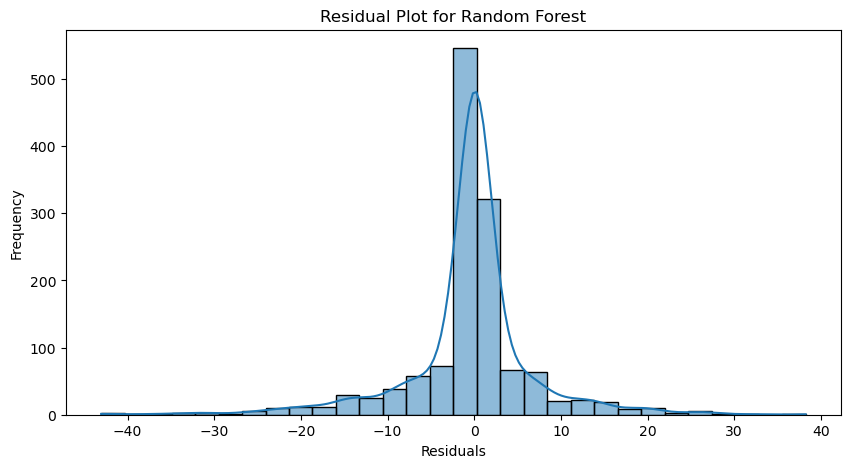

In [472]:
best_model_name = results_df['R2'].idxmax()
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test_scaled)
residuals = y_test - y_pred_best

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f'Residual Plot for {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_28940\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




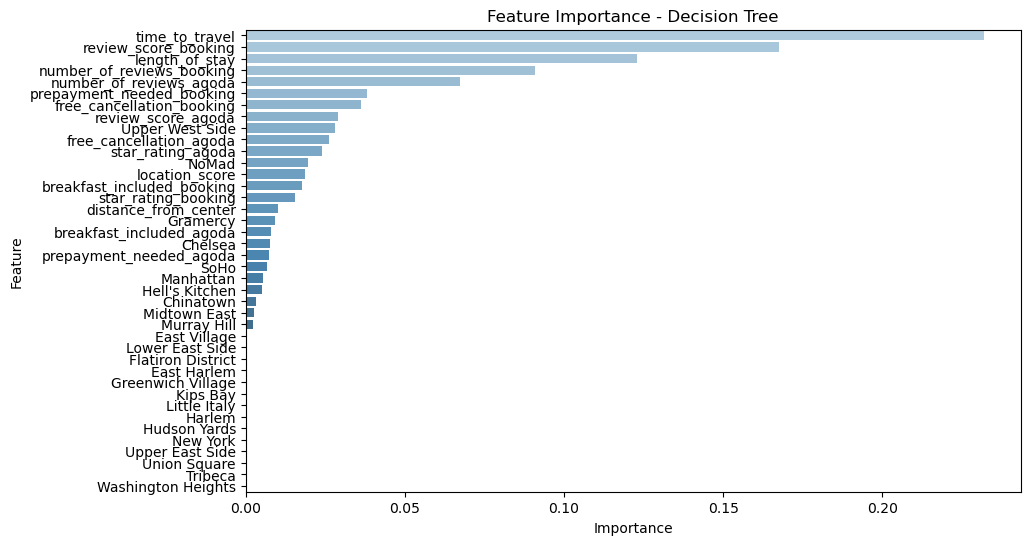

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_28940\572544589.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




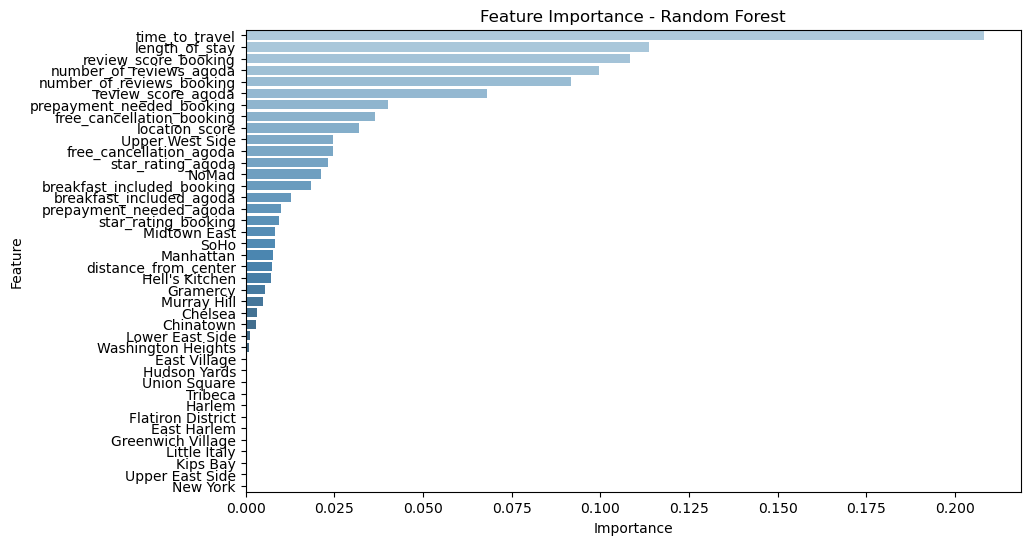

In [473]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    feature_importance = model.feature_importances_
    
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette="Blues_d")
    plt.title(f'Feature Importance - {model_name}')
    plt.show()

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_28940\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




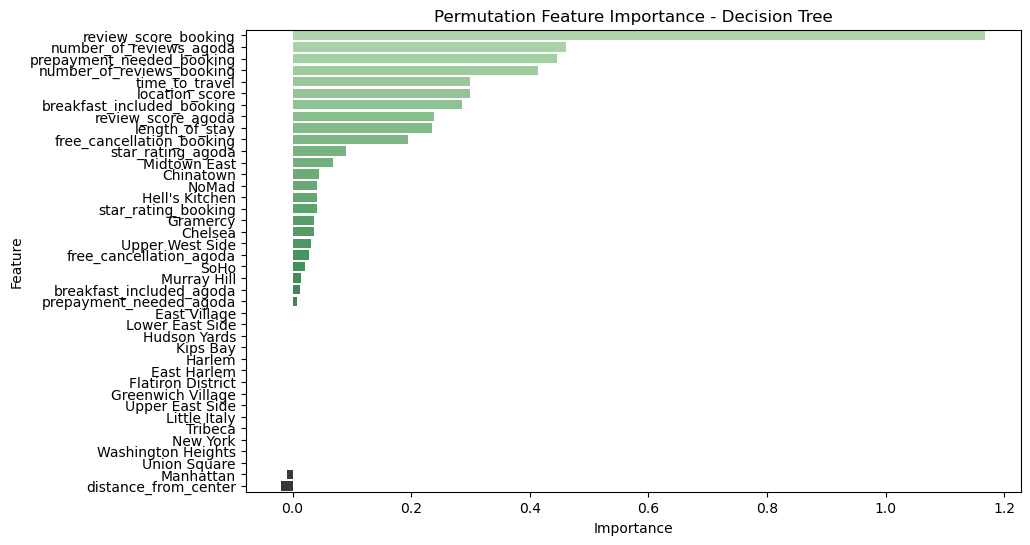

C:\Users\HamamaHome\AppData\Local\Temp\ipykernel_28940\385583814.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




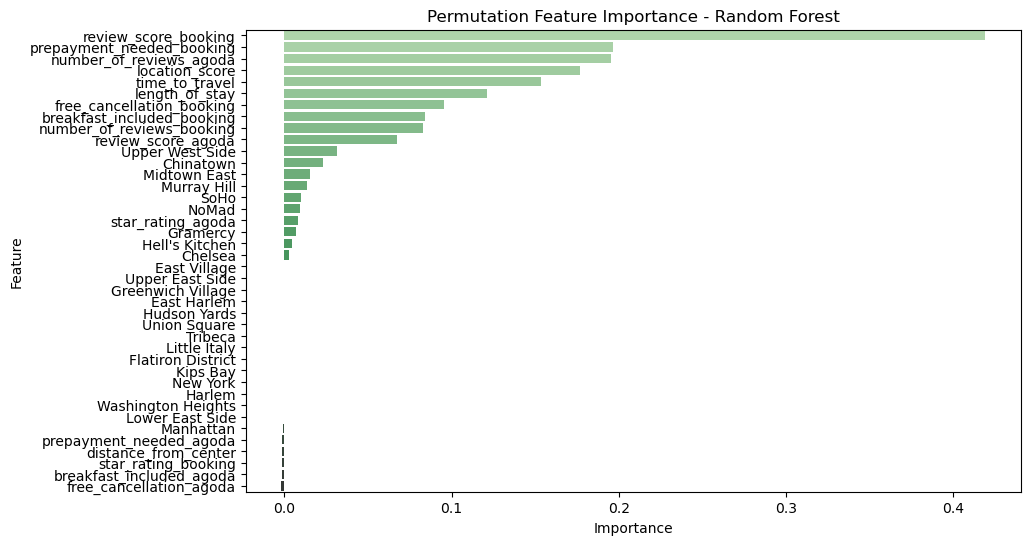

In [474]:
for model_name in ['Decision Tree', 'Random Forest']:
    model = models[model_name]
    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)
    
    perm_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_importance.importances_mean
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=perm_importance_df, palette="Greens_d")
    plt.title(f'Permutation Feature Importance - {model_name}')
    plt.show()
